In [6]:
# standard python utilities
import os
import sys
from os.path import basename, dirname, join, exists, expanduser
import glob
import pandas as pd
import numpy as np
import time
from scipy.stats import gmean

# standard geospatial python utilities
import geopandas as gpd
from osgeo import gdal
import rasterio

# import flopy
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# statistics functions
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import datasets, linear_model
from scipy.stats import pearsonr, spearmanr, kendalltau


In [7]:
usr_dir = expanduser('~')
doc_dir = join(usr_dir, 'Documents')

# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Regional/'

sfr_dir = gwfm_dir+'/SFR_data/'

In [8]:
out_dir = join(proj_dir, 'output')
fig_dir = join(proj_dir, 'figures')

In [9]:
flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)
    
import flopy 

In [10]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'

if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 

loadpth = loadpth +'/GWFlowModel/Cosumnes/Regional/'
base_model_ws = loadpth+'historical_simple_geology_reconnection'
upscale = 8
all_model_ws = join(loadpth, 'parallel_realizations')

m = flopy.modflow.Modflow.load('MF.nam', model_ws= base_model_ws, 
                                exe_name='mf-owhm.exe', version='mfnwt')
print(m.dis.nlay)

19


In [12]:
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
m_domain = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_p.unary_union], crs=grid_p.crs)

In [13]:
sfrdf = pd.DataFrame(m.sfr.reach_data)
grid_sfr = grid_p.set_index(['row','column']).loc[list(zip(sfrdf.i+1,sfrdf.j+1))].reset_index(drop=True)
grid_sfr = pd.concat((grid_sfr,sfrdf),axis=1)

# characterize streambed into different hydrofacies
tprogs_quants = np.array([0.590, 0.155, 0.197, 0.058]).cumsum()
vka_quants = grid_sfr.strhc1.quantile(tprogs_quants)
vka_quants.index=['mud','sandy mud','sand','gravel']
grid_sfr['facies'] = 'mud'
for n in np.arange(0,len(vka_quants)-1):
    grid_sfr.loc[grid_sfr.strhc1 > vka_quants.iloc[n],'facies'] = vka_quants.index[n+1]

# add color for facies plots
gel_color = pd.read_csv(join(gwfm_dir,'UPW_data', 'mf_geology_color_dict.csv'), comment='#')
gel_color.geology = gel_color.geology.str.lower()
grid_sfr = grid_sfr.join(gel_color.set_index('geology')[['color']], on='facies')


In [ ]:
# strt_date = pd.to_datetime(m.dis.start_datetime)
# end_date = (strt_date + pd.Series(m.dis.perlen.array.sum()).astype('timedelta64[D]'))[0]
# # with SS period near 0 no longer minus one
# dates_per = strt_date + (m.dis.perlen.array.cumsum()).astype('timedelta64[D]')
# stplen = m.dis.perlen.array/m.dis.nstp.array
# # astype timedelta64 results in save days
# hrs_from_strt = ((np.append([0], np.repeat(stplen, m.dis.nstp.array)[:-1])).cumsum()*24).astype('timedelta64[h]')
# dates_stps = strt_date + hrs_from_strt

# # get ALL stress periods and time steps list, not just those in the output
# kstpkper = []
# for n,stps in enumerate(m.dis.nstp.array):
#     kstpkper += list(zip(np.arange(0,stps),np.full(stps,n)))

# dt_ref = pd.DataFrame(dates_stps, columns=['dt'])
# dt_ref['kstpkper'] = kstpkper

In [14]:
hdobj = flopy.utils.HeadFile(base_model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()
cbc = base_model_ws+'/MF.cbc'

strt_date = pd.to_datetime(m.dis.start_datetime)
dates = strt_date+(np.asarray(times)-1).astype('timedelta64[D]')

dt_ref = pd.DataFrame(dates, columns=['dt'])
dt_ref['kstpkper'] = spd_stp


# Obs checking

In [15]:
def nse(targets,predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(predictions))**2))

# hob metadata
# rm_grid = pd.read_csv(join(proj_dir, 'mw_hob_cleaned.csv'))


In [16]:
all_obs = pd.read_csv(base_model_ws+'/input_data/all_obs_grid_prepared.csv',index_col=0)
all_obs.index = all_obs.index.rename('date')
all_obs = all_obs.reset_index()
all_obs.date = pd.to_datetime(all_obs.date)
# join more indepth obs data to output simulated heads
# obs_data = hobout.join(all_obs.set_index('obs_nam'),on=['obs_nam'], how='right')
# obs_data = obs_data.dropna(subset=['node'])

In [17]:
def clean_hob(model_ws, all_obs):
    hobout = pd.read_csv(join(model_ws,'MF.hob.out'),delimiter=r'\s+', header = 0,names = ['sim_val','obs_val','obs_nam'],
                         dtype = {'sim_val':float,'obs_val':float,'obs_nam':object},
                        na_values=[-9999.])
    # if only one obs exists correct naming convention
    one_obs = ~hobout.obs_nam.str.contains('.0')
    hobout.loc[one_obs,'obs_nam'] = hobout.loc[one_obs,'obs_nam']+'.'+str(1).zfill(5)
    hobout[['Sensor', 'obs_num']] = hobout.obs_nam.str.split('.',n=2, expand=True)
#     hobout['kstpkper'] = list(zip(np.full(len(hobout),0), hobout.spd.astype(int)))
    hobout.loc[hobout.sim_val.isin([-1e30, -999.99,-9999]), 'sim_val'] = np.nan
    hobout = hobout.dropna(subset='sim_val')
#     hobout = hobout.join(dt_ref.set_index('kstpkper'), on='kstpkper')
    hobout = hobout.join(all_obs.set_index('obs_nam'),on=['obs_nam'], how='right')
    hobout = hobout.dropna(subset=['node'])
    hobout['error'] = hobout.obs_val - hobout.sim_val
    hobout['sq_error'] = hobout.error**2
    return(hobout)

In [38]:
# 
sum_stats = pd.DataFrame(columns=['r2','RMSE','NSE'], dtype=np.float64)
mw_stats = pd.DataFrame(columns=['realization','SOSE','RMSE','NSE'], dtype=np.float64)
for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    hobout = clean_hob(model_ws, all_obs)
    hobout = hobout.dropna(subset='Sensor')

    # summary stats by well
    mw_stats['realization'] = t
    for s in hobout.Sensor.unique():
        df_s = hobout[hobout.Sensor==s]
        mw_stats.loc[s,'SOSE'] = hobout[['Sensor','sq_error']].groupby('Sensor').sum()
        mw_stats.loc[s,'r2'] = r2_score(df_s.obs_val, df_s.sim_val)
        mw_stats.loc[s,'RMSE'] = mean_squared_error(df_s.obs_val, df_s.sim_val, squared=True)
        mw_stats.loc[s,'NSE'] = nse(df_s.obs_val, df_s.sim_val)

    # summary statistics
    sum_stats.loc[t,'r2'] = r2_score(hobout.obs_val, hobout.sim_val)
    sum_stats.loc[t,'RMSE'] = np.sqrt(hobout.sq_error.sum()/len(hobout))
    sum_stats.loc[t,'NSE'] = nse(hobout.obs_val, hobout.sim_val)


In [39]:
# filter out realizations who haven't finished running yet
stats_done = sum_stats[sum_stats.NSE!=sum_stats.NSE.min()].copy()

<Axes: >

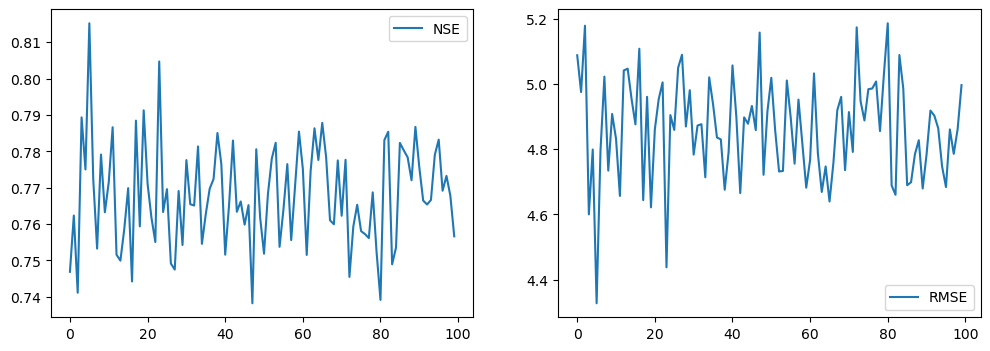

In [40]:
# review to see if error is generally similar between realizations
# review hydrographs for realization with worst error
fig,ax = plt.subplots(1,2, figsize=(12,4))
stats_done.plot(y='NSE', ax=ax[0])
stats_done.plot(y='RMSE', ax=ax[1])


In [42]:
# identify the 10 realizations with the best accuracy
# calculate best score, r2 is tiebreak
stats_done['score'] = (stats_done.NSE >= stats_done.NSE.quantile([0.9]).values[0]).astype(float)
stats_done.score += (stats_done.RMSE <= stats_done.RMSE.quantile([0.1]).values[0]).astype(float)
stats_done.score += (stats_done.r2 >= stats_done.r2.quantile([0.9]).values[0]).astype(float)*0.25
# pull 10 best realizations 
best_realizations = stats_done[stats_done.score >= stats_done.score.quantile([0.9]).values[0]]
print('best realizations', best_realizations.index)
best_realizations.to_csv(join(proj_dir,'top_10_accurate_realizations.csv'))


best realizations Index([3, 5, 11, 17, 19, 23, 42, 63, 65, 82], dtype='int64')


In [45]:
# hobout

In [53]:
# check hydrographs with worst, best, median error
# t = sum_stats['RMSE'].idxmax()
t = sum_stats['RMSE'].idxmin()
# t = sum_stats['NSE'].idxmax()
# approximate median location
# t = sum_stats[1:][(sum_stats[1:].NSE == sum_stats[1:].NSE.median())].index[0]

# t = 45
# t=89
# t=50
print(t)
hobout = clean_hob(join(all_model_ws, 'realization'+ str(t).zfill(3)), all_obs)
hobout = hobout[~hobout.Sensor.isna()]
# removing oneto ag because of large depth offset
hob_long = hobout.melt(id_vars=['date', 'Sensor'],value_vars=['sim_val','obs_val'], value_name='gwe_val')
hob_long['node'] = hob_long.Sensor.str.extract(r'(\d+)').astype(int)
# hob_long

5


C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

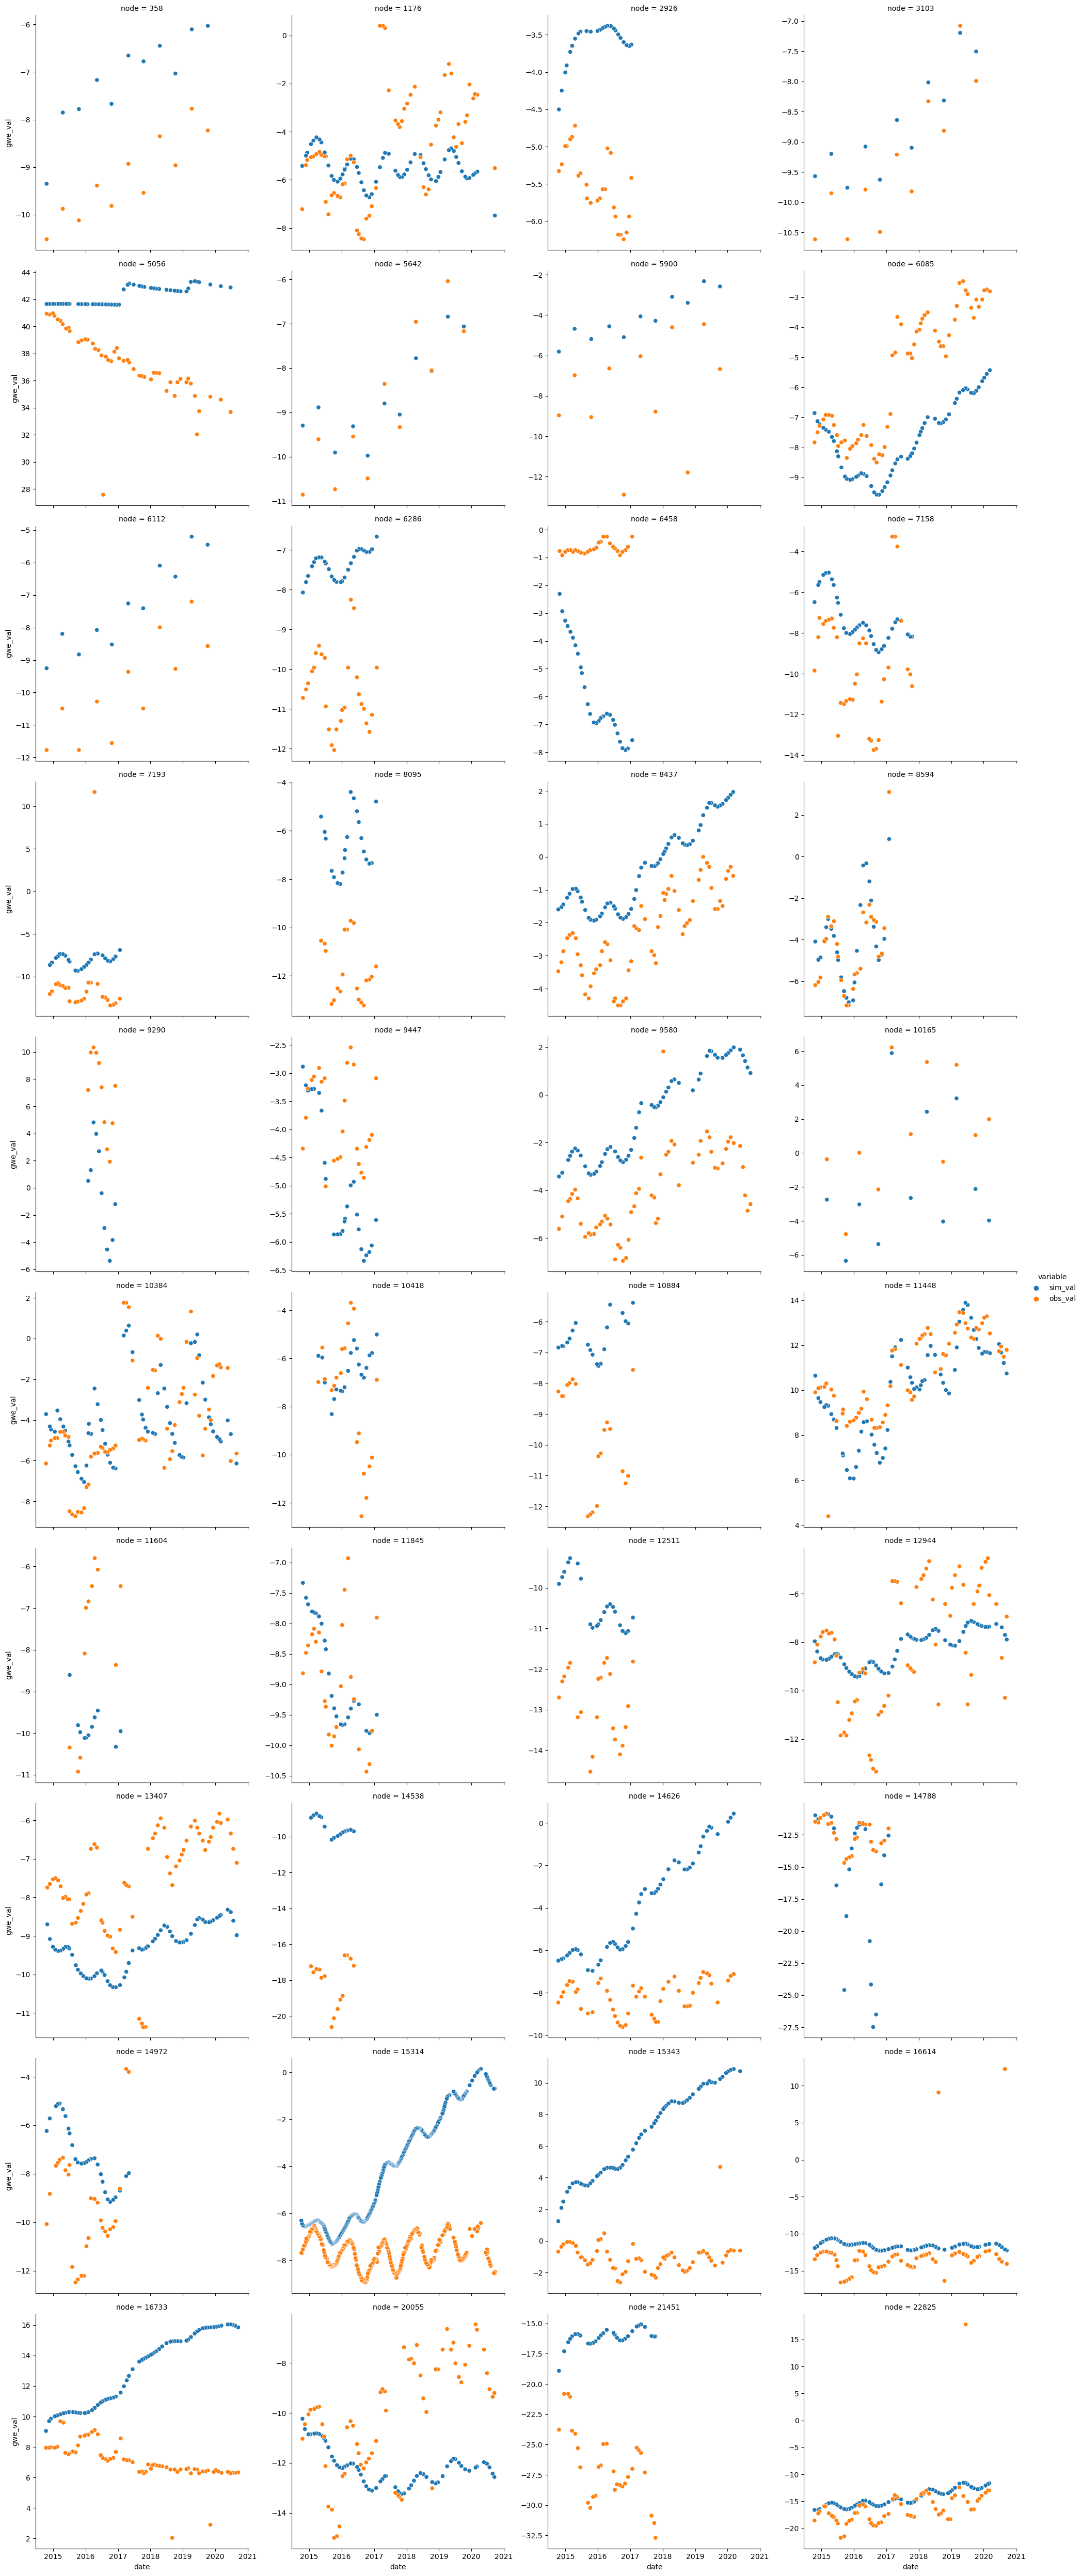

In [54]:
import seaborn as sns
g = sns.relplot(hob_long, x='date',y='gwe_val',col='node',hue='variable', 
                col_wrap=4, 
                facet_kws={'sharey':False})



In [39]:
gage_cols = ['time','stage','volume','conc','inflows','outflows','conductance','error']

def read_gage(gagenam):
    gage = pd.read_csv(gagenam,skiprows=1, delimiter = r'\s+', engine='python')
    cols = gage.columns[1:-1]
    gage = gage.dropna(axis=1)
    gage.columns = cols
    strt_date = pd.to_datetime(m.dis.start_datetime)
    gage['dt'] = strt_date+(gage.Time*24).astype('timedelta64[h]')
    gage = gage.set_index('dt')
    gage['dVolume'] = gage.Volume.diff()
    gage['Total_In'] = gage[['Precip.','Runoff','GW-Inflw','SW-Inflw']].sum(axis=1)
    gage['Total_Out'] = gage[['Evap.','Withdrawal','GW-Outflw','SW-Outflw']].sum(axis=1)
    gage['In-Out'] = gage.Total_In - gage.Total_Out
#     gage['name'] = run
    return(gage)


## Water Budget check

In [2]:
# manual columns
wb_out_cols  =['WEL_OUT','GHB_OUT','SFR_OUT''ET_OUT','LAK_OUT'] #'ET_OUT',,'LAK_OUT'
wb_in_cols = ['RCH_IN','GHB_IN','SFR_IN','LAK_IN'] #,'LAK_IN'

In [3]:
wb_all = pd.DataFrame()
for t in np.arange(0,100): # [50, 89]:
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    # load summary water budget
    wb = pd.read_csv(model_ws+'/flow_budget.txt', delimiter=r'\s+')
    # wb = pd.read_csv(loadpth+'/oneto_denier_upscale8x_2014_2018'+'/flow_budget.txt', delimiter=r'\s+')
    wb['kstpkper'] = list(zip(wb.STP-1,wb.PER-1))
    wb = wb.merge(dt_ref, on='kstpkper')
    wb['realization'] = t
    wb_all = pd.concat((wb_all, wb))


NameError: name 'pd' is not defined

In [ ]:
fig,ax = plt.subplots(5,1, sharex=True, layout='constrained')
for n, wb_n in enumerate(wb_out_cols):
    wb_plt = wb_all.pivot_table(index='dt',columns='realization',values=wb_n)
    wb_plt.plot(legend=False, color='gray', ax=ax[n]) 
    wb_plt.mean(axis=1).plot(color='red',linestyle='--',ax=ax[n])
    ax[n].set_ylabel(wb_out_cols[n].split('_')[0])

# Stream seepage plots

In [47]:
# pd_sfr = grid_sfr.set_index(['iseg','ireach'])[['rchlen','strtop', 'facies', 'color']]
# pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()

def clean_sfr_df(model_ws, drop_iseg):
    ## load sfr reach data ##
    grid_sfr = pd.read_csv(model_ws+'/grid_sfr.csv')
    # remove stream segments for routing purposes only
    grid_sfr = grid_sfr[~grid_sfr.iseg.isin(drop_iseg)]
    pd_sfr = grid_sfr.set_index(['iseg','ireach'])[['rchlen','strtop', 'facies', 'color']]
    pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()
    num_coarse = int(grid_sfr.facies.isin(['Gravel','Sand']).sum())
    
    ## load sfr out file ##
    sfrout = flopy.utils.SfrFile(join(model_ws, m.name+m_ver+'.sfr.out'))
    sfrdf = sfrout.get_dataframe()
    sfrdf = sfrdf.join(dt_ref.set_index('kstpkper'), on='kstpkper').set_index('dt')
    # convert from sub-daily to daily using mean, lose kstpkper
    sfrdf = sfrdf.groupby('segment').resample('D').mean(numeric_only=True)
    sfrdf = sfrdf.reset_index('segment', drop=True)
    sfrdf[['row','column']] = sfrdf[['row','column']].astype(int) - 1 # convert to python
    
    ## join sfr out to reach data ##
    sfrdf = sfrdf.join(pd_sfr ,on=['segment','reach'],how='inner',lsuffix='_all')
    sfrdf['num_coarse'] = num_coarse
    
    ## data transformation for easier manipulation ##
    sfrdf['month'] = sfrdf.index.month
    sfrdf['WY'] = sfrdf.index.year
    sfrdf.loc[sfrdf.month>=10, 'WY'] +=1
    # create column to calculate days flowing
    sfrdf['flowing'] = 1
    sfrdf.loc[sfrdf.Qout <= 0, 'flowing'] = 0
    
    # create different column for stream losing vs gaining seeapge
    sfrdf['Qrech'] = np.where(sfrdf.Qaquifer>0, sfrdf.Qaquifer,0)
    sfrdf['Qbase'] = np.where(sfrdf.Qaquifer<0, sfrdf.Qaquifer*-1,0 )
    # booleans for plotting
    sfrdf['gaining'] = (sfrdf.gradient <= 0)
    sfrdf['losing'] = (sfrdf.gradient >= 0)
    sfrdf['connected'] = (sfrdf.gradient < 1)
    return(sfrdf)



In [48]:
sfrdf =  clean_sfr_df(base_model_ws, drop_iseg)
h_sfrdf =  clean_sfr_df(homogeneous_ws, drop_iseg)


In [49]:
# standardize grouping values
wy_vals = sfrdf.WY.unique()
facies_vals = ['Mud','Sandy Mud','Sand','Gravel']


## Gradient plots (spatial)
1. Seepage averaged across the year (or between dry and wet season) and the rows could be realizations instead which would help indicate consistency across realizations  
2. Heat map of columns with stream segments, rows of dates and the color blue to red for gaining or losing with the seepage averaged across all realizations

When the gradient is greater than 1 we know we have disconnected conditions, I need to represent the count of days where the system is connected.

In [50]:
# aggregate data by facies and sum to review seepage over time
t0 = time.time()

sfr_facies_all = pd.DataFrame()
for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    # remove stream segments for routing purposes
    sfrdf =  clean_sfr_df(model_ws, drop_iseg)
    # summing by facies makes sense for seepage
    sfr_facies_sum = sfrdf.groupby(['dt','facies']).sum(numeric_only=True)
    sfr_facies_sum['realization'] = t
    # count number of facies if needed later for explaining rates
    sfr_facies_sum['num_facies'] = sfrdf.groupby(['dt','facies']).count().iloc[:,0].values
    sfr_facies_all = pd.concat((sfr_facies_all, sfr_facies_sum))
# check time
t1 = time.time()
print('Time: %.2f min' % ((t1-t0)/60))
# save output to speed up reuse
# sfr_facies_all.to_csv(join(out_dir, 'sfrdf_facies_sum.csv'))
sfr_facies_all.reset_index(level='facies').to_hdf(join(out_dir, 'sfrdf_facies_sum.hdf5'), key='dt', complevel=4)

Time: 9.37 min


In [51]:
sfr_facies_all = pd.read_hdf(join(out_dir, 'sfrdf_facies_sum.hdf5'))
# sfr_facies_all = sfr_facies_all.set_index('facies', append=True)

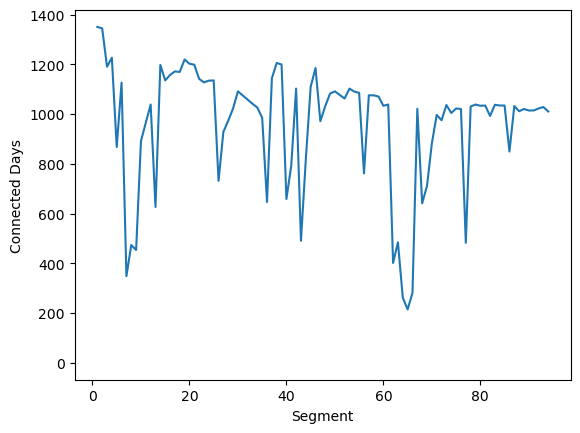

In [52]:
# fig,ax = plt.subplots()

# days connected
df_plt = sfrdf.groupby('segment').sum(numeric_only=True)[['connected']]
ax_conn = df_plt.plot(legend=False)
plt.ylabel('Connected Days')
plt.xlabel('Segment')

for f in sfrdf.facies.unique():
    ax_conn.fill_between(sfrdf.segment, 0, df_plt.max(), where = sfrdf.facies==f,
                    color=gel_color.loc[gel_color.geology==f,'color'], alpha=0.5)

## Notes
In these I need to clarify the proportion of the streambed (length or area) that is each facies to show that despite being only a small percent of the streambed sand and gravel make up a significant portion of recharge and baseflow. 

## Seepage plots (temporal)
Aggregate by facies to plot cumulative seepage (by time) to help show variability caused by geology.

In [53]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='gray', label='Heterogeneous\nRealizations'),
#     Line2D([0], [0], color='black', linestyle='--',label='Homogeneous\nCase'),
    Line2D([0], [0], color='red', linestyle='--', label='Heterogeneous\nMean')
]


Despite being only a small percentage of the stream segments, the sand and gravel produce a significant portion of the stream seepage.

In [54]:
value = 'Qbase'
ylabel  = 'Baseflow ($m^3/d$)'
def plt_dt_facies(value, ylabel):
    # original plotting was 12 by8 but then text is very small
    fig,ax = plt.subplots(2,2, figsize=(8,5.3), sharex=True, sharey=True, layout='constrained')#
    facies = ['Mud','Sandy Mud','Sand','Gravel']
    for t in np.arange(0,100):
        sfr_facies_sum = sfr_facies_all[sfr_facies_all.realization==t]
        for n,f in enumerate(facies):
            ax_n = ax[int(n/2), n%2]
            df_plt = sfr_facies_sum[sfr_facies_sum.facies==f]
            if df_plt.shape[0]>0:
                df_plt.plot(y=value, ax=ax_n, legend=False, color='gray')
    # plot homogeneous case
#     h_sfr_facies_sum = h_sfrdf.groupby(['dt','facies']).sum(numeric_only=True)
    # plot mean of heterogeneous
#     sfr_facies_mean = sfr_facies_all.groupby(['dt', 'facies','realization']).sum(numeric_only=True)
    sfr_facies_mean = sfr_facies_all.groupby(['dt', 'facies']).mean().reset_index('facies')
    # set axis labels
    for n,f in enumerate(facies):
        ax_n = ax[int(n/2), n%2]
        h_sfr_facies_sum.reset_index('facies').plot(y=value, ax=ax_n, legend=False, color='black', linestyle='--')
        sfr_facies_mean[sfr_facies_mean.facies==f].plot(y=value, ax=ax_n, legend=False, color='red', linestyle='--')
        ax_n.set_title(f)
        ax_n.set_yscale('log')
        ax_n.set_ylabel(ylabel)
        ax_n.set_xlabel('Date')
    # add figure legend
    fig.legend(handles=legend_elements, loc='outside upper center', ncol = 3)


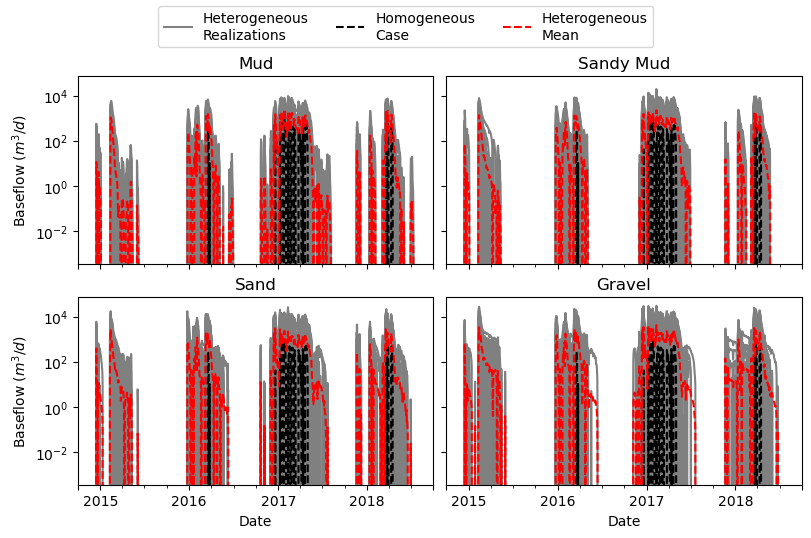

In [55]:
value = 'Qbase'
plt_dt_facies(value, ylabel)
# ax.legend(handles=legend_elements, loc='lower right')


In [56]:
# value = 'Qrech'
# ylabel  = 'Stream Seepage ($m^3/d$)'
# plt_dt_facies(value, ylabel)


In [57]:
# is it worth plotting the change in groundwater storage when there isn't a clear area to track
# I could assume a buffer distance of 1000 m but that may not be enough or could be too much
sfrdf.columns

Index(['layer', 'row', 'column', 'segment', 'reach', 'Qin', 'Qaquifer', 'Qout',
       'Qovr', 'Qprecip', 'Qet', 'stage', 'depth', 'width', 'Cond', 'gradient',
       'strtop_all', 'k', 'i', 'j', 'rchlen', 'strtop', 'facies', 'color',
       'Total distance (m)', 'num_coarse', 'month', 'WY', 'flowing', 'Qrech',
       'Qbase', 'gaining', 'losing', 'connected'],
      dtype='object')

## Streamflow
No need to aggregate by facies, instead show impact at downstream end in terms of time step and cumulative

In [58]:
sfr_last_all = pd.DataFrame()
for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    sfrdf =  clean_sfr_df(model_ws, drop_iseg)
    # plot from last segment (shows cumulative effects)
    sfr_last = sfrdf[sfrdf.segment==sfrdf.segment.max()].copy()
    sfr_last['realization'] = t
    sfr_last_all = pd.concat((sfr_last_all, sfr_last))

# save data
sfr_last_all.to_hdf(join(out_dir, 'sfrdf_last_seg.hdf5'), key='dt', complevel=4)

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_132088\78463392.py:11: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['facies', 'color'], dtype='object')]

  sfr_last_all.to_hdf(join(out_dir, 'sfrdf_last_seg.hdf5'), key='dt', complevel=4)


In [59]:
sfr_last_all = pd.read_hdf(join(out_dir, 'sfrdf_last_seg.hdf5'))

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_132088\3177288223.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sfr_last_mean = sfr_last_all.groupby('dt').mean()


Time: 0.11 min


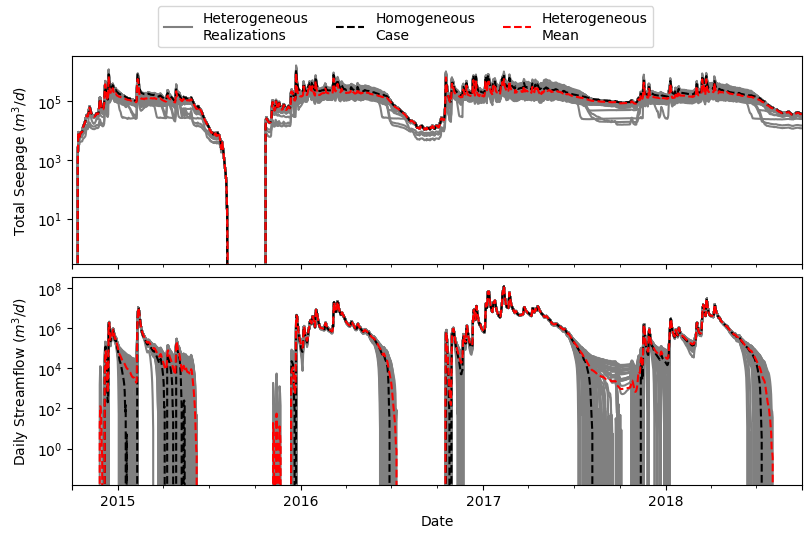

In [60]:
t0 = time.time()
fig,ax = plt.subplots(2,1, figsize=(8,5.3), sharex=True, sharey=False, layout='constrained',)

for t in np.arange(0,100):
    sfr_last = sfr_last_all[sfr_last_all.realization==t]
    sfr_last.plot(y='Qin', ax=ax[1], legend=False, color='gray')
    sfr_seg = sfr_facies_all[sfr_facies_all.realization==t].groupby('dt').sum(numeric_only=True)
    sfr_seg.plot(y='Qaquifer', ax=ax[0], legend=False, color='gray')

# plot homogeneous case
# h_sfr_last = h_sfrdf[h_sfrdf.segment==h_sfrdf.segment.max()]
# h_sfr_last.plot(y='Qin', ax=ax[1], legend=False, color='black',linestyle='--')
# h_sfrdf.groupby('dt').sum(numeric_only=True).plot(y='Qaquifer', ax=ax[0], legend=False, color='black', linestyle='--')
# plot mean of heterogeneous
sfr_last_mean = sfr_last_all.groupby('dt').mean()
sfr_last_mean.plot(y='Qin', ax=ax[1], legend=False, color='red',linestyle='--')
sfr_sum_mean = sfr_facies_all.groupby(['dt', 'realization']).sum(numeric_only=True).groupby('dt').mean()
sfr_sum_mean.plot(y='Qaquifer', ax=ax[0], legend=False, color='red', linestyle='--')

# set axis labels
ax[1].set_ylabel('Daily Streamflow ($m^3/d$)')
ax[1].set_xlabel('Date')
ax[1].set_yscale('log')
ax[0].set_ylabel('Total Seepage ($m^3/d$)')
# need log scale or peaks wash out other data
ax[0].set_yscale('log')
fig.legend(handles=legend_elements, loc='outside upper center', ncol = 3)

# fig.tight_layout()

t1 = time.time()
print('Time: %.2f min' % ((t1-t0)/60))


## Scatter plots
**Goal**: relate the heterogeneity (e.g., number of coarse bodies connecting to the stream) to the number of days with streamflow.

Need to save data as an aggregated dataframe to run trend analysis

In [61]:
t0 = time.time()

sfr_3mon_all = pd.DataFrame()
sfr_yr_sum_all = pd.DataFrame()

for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    # clean sfr output
    sfrdf =  clean_sfr_df(model_ws, drop_iseg)
    sfrdf['realization'] = t
    num_coarse = sfrdf['num_coarse'].mean()
    # aggregate to seasonal values, since model starts in october it groups as oct-dec, jan-mar, apr-jun, jul-sep
    sfrdf_mon = sfrdf.resample('3MS').mean(numeric_only=True)
    sfrdf_mon['realization'] = t
    sfrdf_mon['num_coarse'] = num_coarse
    sfr_3mon_all = pd.concat((sfr_3mon_all, sfrdf_mon))
    # aggregate to annual values for each segment
    sfrdf_yr_sum = sfrdf.groupby(['WY','segment']).sum(numeric_only=True)
    sfrdf_yr_sum['realization'] = t
    sfrdf_yr_sum['num_coarse'] = num_coarse
    sfr_yr_sum_all = pd.concat((sfr_yr_sum_all, sfrdf_yr_sum))
# check time
t1 = time.time()
print('Time: %.2f min' % ((t1-t0)/60))

# save output to speed up reuse
sfr_3mon_all.to_csv(join(out_dir, 'sfrdf_3month_mean.csv'))
sfr_yr_sum_all.to_csv(join(out_dir, 'sfrdf_annual_sum_by_segment.csv'))

Time: 6.70 min


In [62]:
# load previously made output to speed up reuse
sfr_3mon_all = pd.read_csv(join(out_dir, 'sfrdf_3month_mean.csv'), parse_dates=['dt'], index_col='dt')
# fix issue where this was averaged
sfr_3mon_all.month = sfr_3mon_all.index.month
sfr_yr_sum_all = pd.read_csv(join(out_dir, 'sfrdf_annual_sum_by_segment.csv'), index_col=['WY','segment'])

In [63]:
# after resampling if need to re-identify the number of coarse in a stream
coarse_ref = sfr_3mon_all.groupby('realization').mean(numeric_only=True)[['num_coarse']]

In [64]:
# sfr_seg_all = pd.DataFrame()
# for t in np.arange(0,100):
#     ## plot the connected days ##
#     sfr_seg = sfrdf.groupby('segment').sum(numeric_only=True)[['connected']]
#     sfr_seg_all = pd.concat((sfr_seg_all, sfr_seg))

In [65]:

def plt_wy_seg(value, ylabel):
    fig,ax = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True, layout='constrained')
    wy_unique = sfr_yr_sum_all.index.get_level_values('WY').unique()

    for t in np.arange(0,100):
        sfr_yr_sum = sfr_yr_sum_all[sfr_yr_sum_all.realization==t].reset_index('WY')
        for n,f in enumerate(wy_unique):
            ax_n = ax[int(n/2), n%2]
            df_plt = sfr_yr_sum[sfr_yr_sum.WY==f]
            if df_plt.shape[0]>0:
                df_plt.plot(y=value, ax=ax_n, legend=False, color='gray')

    # plot homogeneous case
#     h_sfr_yr_sum = h_sfrdf.groupby(['WY', 'segment']).sum(numeric_only=True).reset_index('WY')
    # plot mean of heterogeneous
    sfr_yr_sum_mean = sfr_yr_sum_all.groupby(['WY','segment']).mean().reset_index('WY')
    # set axis labels
    for n,f in enumerate(wy_unique):
        ax_n = ax[int(n/2), n%2]
        h_sfr_yr_sum[h_sfr_yr_sum.WY==f].plot(y=value, ax=ax_n, legend=False, color='black', linestyle='--')
        sfr_yr_sum_mean[sfr_yr_sum_mean.WY==f].plot(y=value, ax=ax_n, legend=False, color='red', linestyle='--')
        ax_n.set_title(f)
        ax_n.set_ylabel(ylabel)
        ax_n.set_xlabel('Segment')
    #     ax_n.set_yscale('log')
#     fig.tight_layout()
#     fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=[0.55, 1.03], ncol = 3)
    fig.legend(handles=legend_elements, loc='outside upper center', ncol = 3)


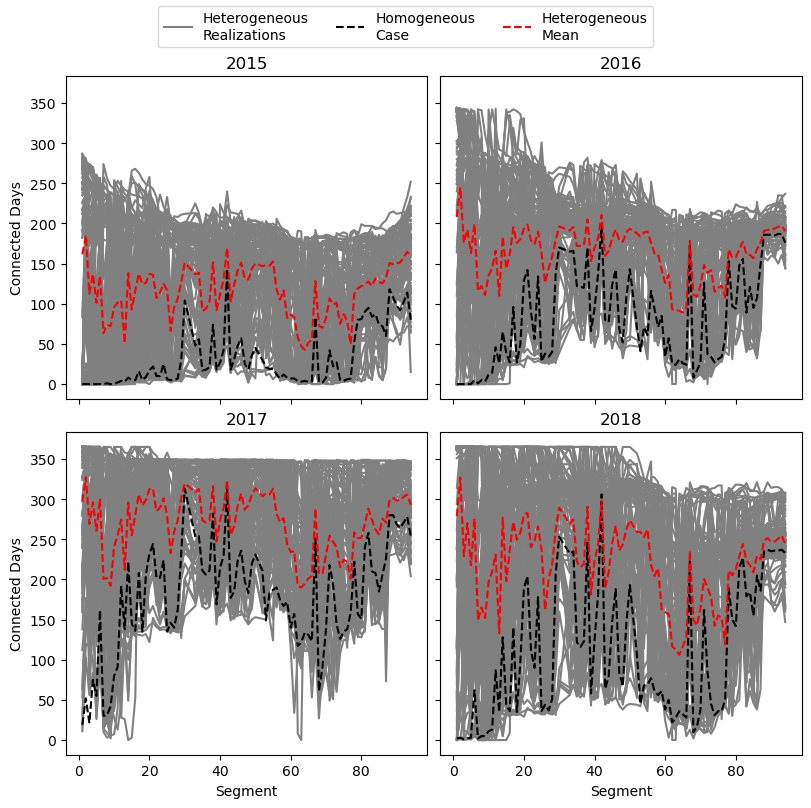

In [66]:
value = 'connected'
ylabel = 'Connected Days'
plt_wy_seg(value, ylabel)
# ax.legend(handles=legend_elements, loc='lower right')


The days with flow drops off at segment 31 because half of the flow becomes over bank flow to the floodplain so less water remains in the channel to recharge near the channel.

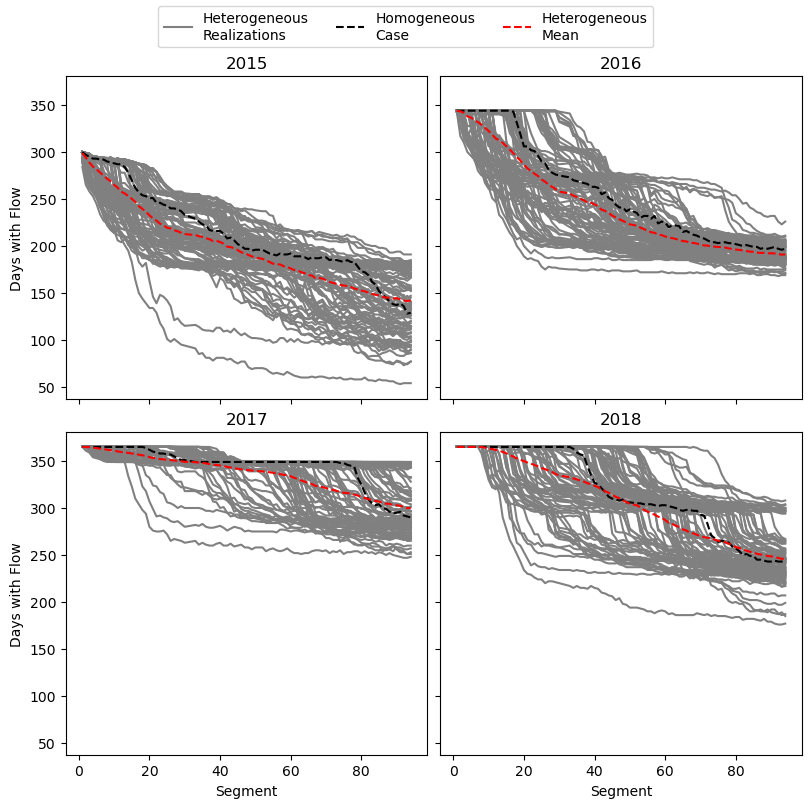

In [67]:
value = 'flowing'
ylabel = 'Days with Flow'
plt_wy_seg(value, ylabel)

In [81]:
# need to see why water could be leaving the lake in a few scenarios
# g = sns.relplot(sfr_yr_sum_all, x='segment',y='flowing', col='WY', col_wrap=2, hue='realization', #color='gray', 
#            facet_kws={'sharey': False, 'sharex': True})



In [470]:
# import seaborn as sns

# g = sns.relplot(sfrdf_all, x='num_coarse',y='Qbase', col= 'month', row='WY', color='gray', 
#            facet_kws={'sharey': False, 'sharex': True})

